In [11]:
.libPaths("C:/WFS_new/WFS/Personal R Libary")

library(bnlearn)
library(tidyverse)
library(graph)
library(gRbase)
library(gRain)

In [14]:
Data<-read_csv("./data/output/Data_RASFF_EMA_new.csv") 

Data<-Data %>% filter(Data_source=="RASFF")%>% select(-Data_source) %>% rename(Fraud=Product_fraudtype,Product=Product_category,Notified=`Ct_country-name`,Origin=`Or_country-name`)  %>% filter(Year>=2014)


Data<-Data %>% mutate_if(is.numeric,as.character)

Data[is.na(Data)]<-"Missing data"






set.seed(0)


Sampled_rows<-sample(1:length(Data$Fraud),ceiling(length(Data$Fraud)*0.2),rep=FALSE)

BNdata_train<-Data[-Sampled_rows,]

BNdata_test<-Data[Sampled_rows,]

BNdata_train<-BNdata_train %>%  mutate_if(is.character,as.factor)


BNdata_test<-BNdata_test %>%  mutate_if(is.character,as.factor)


write.csv(BNdata_train,"./data/output/BNdata_train_2014_2018.csv",row.names = FALSE)
write.csv(BNdata_test,"./data/output/BNdata_test_2014_2018.csv",row.names = FALSE)


Rows: 441 Columns: 6

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Data_source, Product_category, Or_country-name, Ct_country-name, Pr...
dbl (1): Year


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



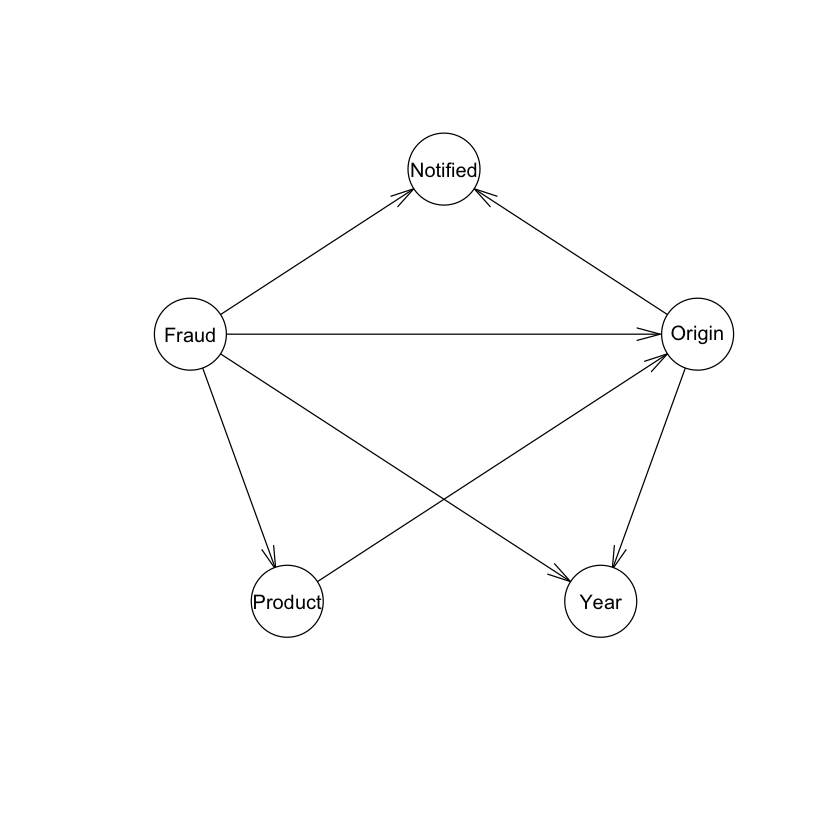

In [15]:
BNdata_train<-as.data.frame(BNdata_train)
BNdata_test<- as.data.frame(BNdata_test)

#structure leaning
BN_structure<- tree.bayes(BNdata_train,'Fraud')

## test other learning algorithms #

#BN_structure<-gs(BNdata_train)  ### Grow-Shrink (GS) Constraint-based algorithm
#BN_structure<-iamb(BNdata_train)### The incremental association Markov boundary algorithm
#BN_structure<-hc(BNdata_train)### Hill climbing algorithm

graphics::plot(BN_structure)
#graphviz.plot(BN_structure, shape = "ellipse")

In [16]:
BIC(BN_structure, BNdata_train)

[1] -3272.512

In [17]:
## parameter learning
BN_trained<-bn.fit(x=BN_structure,data=BNdata_train,method = "bayes")

## convert to gRain
fitted.grain = as.grain(BN_trained)

In [18]:
#Retrieve marginal probability distribution of each node
Mprobs = querygrain(fitted.grain, type = "marginal")
Mprobs 

$Fraud
Fraud
Smuggling-Mislabelling-Origin Masking                 Substitution-Dilution 
                           0.92672414                            0.07327586 

$Product
Product
                    Coffee              Confectionary 
               0.009159483                0.017780172 
                      Eggs               Fish_Seafood 
               0.009159483                0.216056034 
Food_additives_supplements                     Fruits 
               0.078125000                0.009159483 
              Herbs_spices                       Meat 
               0.035021552                0.078125000 
                      Nuts                  Oils_Fats 
               0.155711207                0.017780172 
                   Poultry             Prepared_meals 
               0.043642241                0.095366379 
                    Snacks                Soups_sauce 
               0.009159483                0.026400862 
                       Tea                 Vegetables 
               0.009159483                0.190193966 

$Origin
Origin
   Australia   Bangladesh      Belgium       Brazil        China        Ghana 
 0.026340996  0.069444444  0.017720307  0.009099617  0.181513410  0.129789272 
        Iran        Italy        Japan      Morocco      Myanmar      Nigeria 
 0.034961686  0.009099617  0.009099617  0.017720307  0.017720307  0.276340996 
 Philippines      Senegal South Africa     Thailand       Turkey      Vietnam 
 0.026340996  0.026340996  0.009099617  0.069444444  0.017720307  0.052203065 

$Year
Year
     2014      2015      2016      2017      2018 
0.1741379 0.1655172 0.2172414 0.2948276 0.1482759 

$Notified
Notified
       Belgium         Cyprus        Estonia         Greece        Iceland 
    0.01790451     0.00928382     0.00928382     0.00928382     0.00928382 
         Italy    Netherlands         Norway       Portugal          Spain 
    0.09549072     0.01790451     0.10411141     0.02652520     0.10411141 
        Sweden    Switzerland United Kingdom 
    0.00928382     0.00928382     0.57824934

In [19]:
## internal validation: confusion matrix
pred_in <- predict(fitted.grain , response = c("Fraud"), newdata = BNdata_train, type = "class")
pred_in <- as.data.frame(pred_in)

table(BNdata_train$Fraud,pred_in$Fraud)
Detection_probability_inter<-sum(diag(table(BNdata_train$Fraud,pred_in$Fraud)))/
  sum(table(BNdata_train$Fraud,pred_in$Fraud))
Detection_probability_inter


                                       
                                        Smuggling-Mislabelling-Origin Masking
  Smuggling-Mislabelling-Origin Masking                                   106
  Substitution-Dilution                                                     1
                                       
                                        Substitution-Dilution
  Smuggling-Mislabelling-Origin Masking                     1
  Substitution-Dilution                                     7

[1] 0.9826087

In [20]:
## external validation: confusion matrix
pred_ex <- predict(fitted.grain, response = c("Fraud"), newdata=BNdata_test, type = "class")

pred_ex <- as.data.frame(pred_ex)


f2<-as.factor(pred_ex$Fraud)

levels(f2) <- c(levels(f2),"Artificial enhancement/Improvement")
f2=ordered(f2, levels = c(" Artificial enhancement/Improvement", "Smuggling-Mislabelling-Origin Masking", "Substitution-Dilution"))


f2<-as.data.frame(f2)

pred_ex$Fraud<-f2$f2



table(BNdata_test$Fraud,pred_ex$Fraud)
Detection_probability_exter<-sum(diag(table(BNdata_test$Fraud,pred_ex$Fraud)))/sum(table(BNdata_test$Fraud,pred_ex$Fraud))
Detection_probability_exter

                                       
                                         Artificial enhancement/Improvement
  Artificial enhancement/Improvement                                      0
  Smuggling-Mislabelling-Origin Masking                                   0
                                       
                                        Smuggling-Mislabelling-Origin Masking
  Artificial enhancement/Improvement                                        0
  Smuggling-Mislabelling-Origin Masking                                    26
                                       
                                        Substitution-Dilution
  Artificial enhancement/Improvement                        1
  Smuggling-Mislabelling-Origin Masking                     2

[1] 0.8965517